# Assignment 8
- In this assignment we write code to implement the Delay-and-Sum Algorithm used commonly used in Ultrasound Image Reconstruction

In [212]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

Now we set the main system parameters up: Number of Mics, Number of Samples in Time, Location of Source, Location of Obstacle, Speed of Sound, Narrowness of Sinc Pulse, Location of Mics

In [213]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200

# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)

# Spacing between microphones
pitch = 0.1

# proxy for sampling rate
dist_per_samp = 0.1

# Speed of sound in the medium
C = 0.5

# Time dilation factor for sinc pulse: how narrow
SincP = 1

# Locations of microphones
mics = []
    
# Location of point obstacle
obstacle = (3, -1)

#Finding Time per Sample from Distance per Sample:
time_per_sample = dist_per_samp/C

### Wave Emitted by Source
We model the wave emitted by the source as a sinc pulse, defined as:
$$sinc(x)=\frac{sin(x)}{x}

In [214]:
# Wave emitted by the source
def wsrc(t):
    return np.sinc(SincP*t)

### Questions Given Regarding $sinc(x)$
- In the above definition of `wsrc(t)`, the value `SincP` is the dilating factor. Increasing it will cause the graph to be narrower.
- Graphs for Different values of SincP are given below:

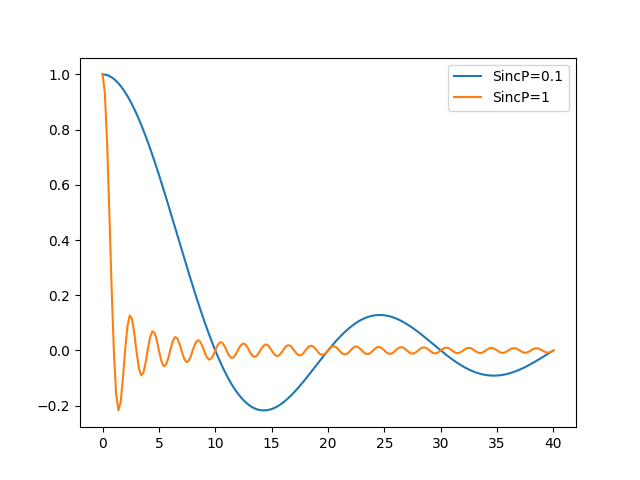

In [215]:
t = np.linspace(0, Nsamp*time_per_sample, Nsamp)

plt.figure()
# Graph with Sincp=0.1
y1 = np.sinc(0.1 * t)
plt.plot(t,y1,label="SincP=0.1")

# Graph with Sincp=1
y2 = wsrc(1 * t)
plt.plot(t, y2,label="SincP=1")

plt.legend()
plt.show()


The following function calculates the distance from source to point and then to mic. This is used since we use the whole idea that the wave travels to a point, reflects from there and reaches the mic

In [216]:
# Find the distance from source to a point and then to mic
def dist(src, pt, mic):
    d1 = np.sqrt((src[0]-pt[0])**2 + (src[1]-pt[1])**2) # Distance from src to pt
    d2 = np.sqrt((mic[0]-pt[0])**2 + (mic[1]-pt[1])**2) # Distance from pt to mic
    return d1 + d2

## Setup and Generating Mic Output

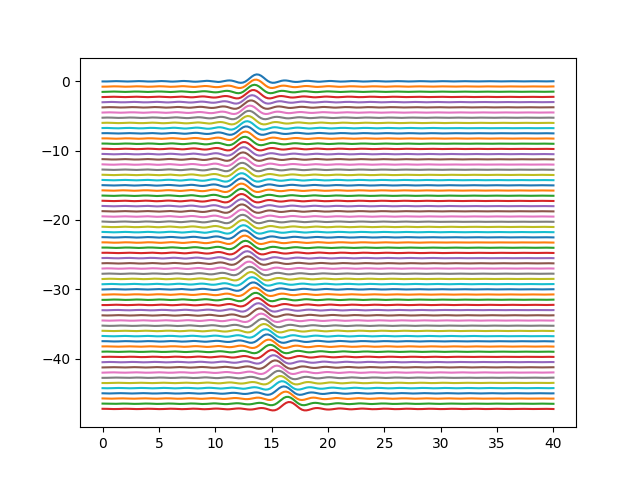

In [217]:
# Setting up Location of Mics
y_mic = []
if Nmics % 2 == 0:
    for element in range(-int(Nmics/2), int(Nmics/2)):
        y_mic.append(pitch/2 + element*pitch)
else:
    for element in range(-int(Nmics/2), int((Nmics+1)/2)):
        y_mic.append(element*pitch)

x_mic = [0] * len(y_mic)
mics = np.array([x_mic,y_mic])
mics = mics.transpose()

# Creating Domain of Time t
t = np.linspace(0, Nsamp*time_per_sample, Nsamp)

# To shift y values so as to plot output of all mics in a graph
offset = 0

# Calculating Output Waves from Mics
plt.figure()
mic_outputs = []
for mic in range(Nmics):

    # Output gets delayed by time_delay
    time_delay = dist(src, obstacle, mics[mic])/C
    y_time_delay=wsrc(t-time_delay)

    # Plot the value and store delayed signal
    plt.plot(t, y_time_delay+offset)
    mic_outputs.append(y_time_delay)

    offset -=0.75
mic_outputs=np.array(mic_outputs)

### Heatmap

The heatmap for the output from the mics is given below

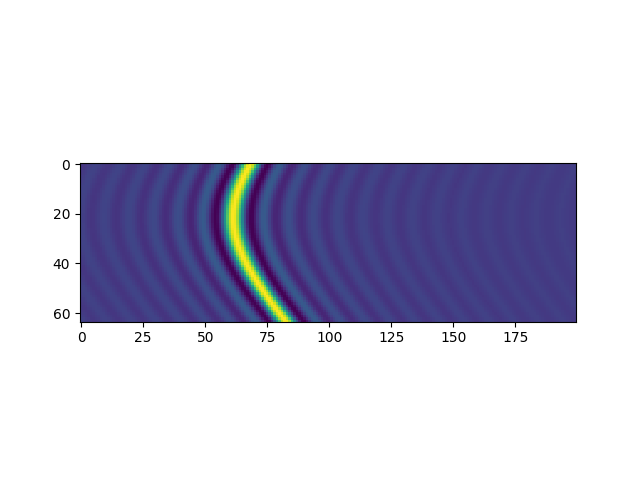

In [218]:
# Heatmap for the same data

plt.figure()
plt.imshow(mic_outputs,cmap='viridis', interpolation='nearest')
plt.show()

## Determining Position of Obstacle Using DAS
### Question
- Does it make sense to reconstruct up to `Nsamp`? What value is more reasonable as an upper limit for the x-axis here?

### Answer
- No, you do not necessarily need to reconstruct up to `Nsamp`. We only have to go till `Nsamp/2`
- The maximum Time delay a mic output can have is `Nsamp * time\_per\_samp`
- Thus, we can detect upto a distance of `Nsamp*dist_per_samp/2`. This means we have to go only upto `Nsamp/2`

Below is the code to implement DAS and Display the heatmap of position of object:

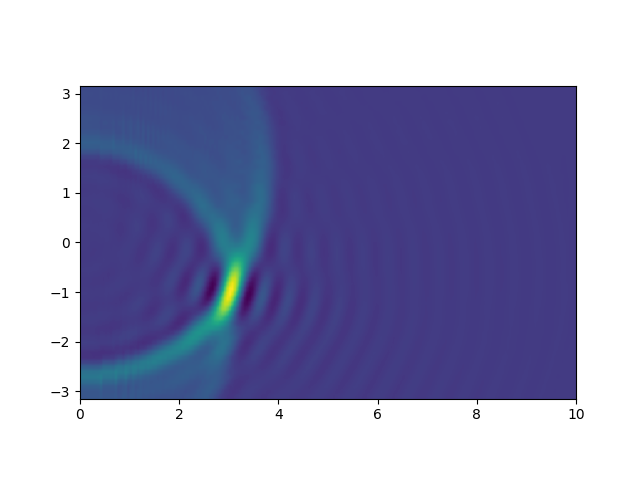

In [219]:
# Setting up Grid of all (x,y) to Check
X,Y = np.meshgrid(np.arange(Nsamp)*dist_per_samp/2, -1 * mics.transpose()[1])

# Finding Sum of Mic Output Corresponding to all mics:
Z = []
for i in range(len(X)):
    row_outputs = []
    for j in range(len(X[0])):
        
        # Find sum of the values from all mics:
        output_sum = 0
        for mic in range(Nmics):
            time_delay = dist(src, [X[i][j], Y[i][j]], mics[mic]) / C
            if int(time_delay / time_per_sample) >= Nsamp:
                output_sum += 0
            else:
                output_sum += mic_outputs[mic][int(time_delay / time_per_sample)]
        row_outputs.append(output_sum)

    Z.append(row_outputs)

summed_outputs_array = np.array(Z)

plt.figure()
# Display the heatmap of the position of the Obstacle
plt.imshow(summed_outputs_array, extent=[0, Nsamp * dist_per_samp / 2, mics[0][1], mics[-1][1]])
plt.savefig(f"{Nmics}_{Nsamp}.png")
plt.show()

## Questions
1. The (x, y) coordinates corresponding to the maximum amplitude (yellow colour) is approximately (30, 22). Explain why this is the correct expected position for the given obstacle.

2. What is the maximum obstacle x- and y- coordinate that you can use and still have an image reconstructed?

3. What happens if C is different - if C is decreased it looks like the image becomes sharper. Can you explain why intuitively?

4. What happens if Nmics is increased or decreased? Do the experiments with Nmics = [8, 32, 64] and Nsamp = [50, 100, 200] (all combinations). Attach the resulting images.

## Answers
1. 30 represents the No. of samples. The distance on the X- Axis is, hence, `30*pitch` = 30 * .1. This represents 3 in the X axis. 22 represents the 23rd mic from the bottom, This implies that it has a y-coordinate close to -1.

2. The maximum value of (X,Y) can only be the values for which `max(dist_delay)` = source to obstacle + obstacle to Farthest mic does not exceed `Nsamp*dis_per_samp`.

3. If C is decreased, we get a larger interval of time for which the source is active. This means you get more delays for each calculation. Due to this, you end up with sharper values.

4. I have attached the Heatmaps for these in my report. It can be observed that as Nmics is decreased we get a less sharper image. This is pretty intuitive as well, because the greater the number of mics you have, you will be able to measure changes in delays


## Reconstruction from the Datasets given
- The following code implements DAS and reconstructs the object locations for the datasets given.
- Uncomment the function call in the end of the code to see output. Also, ensure that the file is uploaded in the same directory as this Notebook

In [220]:
def DAS_Recon(file):
    # Main Parameters
    Nmics = 64
    Nsamp = 200
    pitch = 0.1
    dist_per_samp = 0.1
    C = 0.5
    time_per_sample = dist_per_samp/C

    # Setting up Mic Locations
    y_mic = []
    if Nmics % 2 == 0:
        for element in range(-int(Nmics/2), int(Nmics/2)):
            y_mic.append(pitch/2 + element*pitch)
    else:
        for element in range(-int(Nmics/2), int((Nmics+1)/2)):
            y_mic.append(element*pitch)

    x_mic = [0] * len(y_mic)
    mics = np.array([x_mic,y_mic])
    mics = mics.transpose()

    # Reading Data from file
    mic_outputs = np.loadtxt(file)
    
    t = np.linspace(0, Nsamp*time_per_sample, Nsamp)

    # Setting up Grid of all (x,y) to Check
    X,Y = np.meshgrid(np.arange(Nsamp)*dist_per_samp/2, -1 * mics.transpose()[1])

    # Finding Sum of Mic Output Corresponding to all mics:
    Z = []
    for i in range(len(X)):
        row_outputs = []
        for j in range(len(X[0])):
            
            # Find sum of the values from all mics:
            output_sum = 0
            for mic in range(Nmics):
                time_delay = dist(src, [X[i][j], Y[i][j]], mics[mic]) / C
                if int(time_delay / time_per_sample) >= Nsamp:
                    output_sum += 0
                else:
                    output_sum += mic_outputs[mic][int(time_delay / time_per_sample)]
            row_outputs.append(output_sum)

        Z.append(row_outputs)

    summed_outputs_array = np.array(Z)

    plt.figure()
    plt.imshow(summed_outputs_array, extent=[0,Nsamp*dist_per_samp/2,mics[0][1],mics[-1][1]])
    plt.show()

# DAS_Recon("rx2.txt")
# DAS_Recon("rx2.txt")